### Examples of Questions that Combine All Databases

This notebook contains code that answers questions that require all data sources and databases.

In [10]:
import sys
sys.path.append('../')

In [11]:
from py2neo import Graph
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import trends.trends_to_redis as trends_to_redis
import numpy as np

In [ ]:
DOWNLOADS_FOLDER_FP = "<YOUR DOWNLOADS FOLDER>"
YOUR_USERNAME = "<YOUR USERNAME>"

### Do the most prolific artists from the 2 most influential movements trend together?

Step 1: Find the 2 most influential movements using Neo4j

In [ ]:
# Connect to your Neo4j database
# Replace with your actual connection details
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

In [5]:
# complex query that considers multiple factors for influence
complex_query = """
MATCH (m:Movement)
WHERE m.name <> "Unknown"
OPTIONAL MATCH (m)<-[:BELONGS_TO_MOVEMENT]-(a:Artist)
WITH m, count(DISTINCT a) AS artist_count

OPTIONAL MATCH (m)<-[:BELONGS_TO_MOVEMENT]-(a:Artist)-[:CREATED]->(artwork:Artwork)
WITH m, artist_count, count(DISTINCT artwork) AS artwork_count

OPTIONAL MATCH (m)<-[:BELONGS_TO_MOVEMENT]-(a1:Artist)-[:INFLUENCED]->(a2:Artist)
WITH m, artist_count, artwork_count, count(DISTINCT a2) AS influenced_artists

OPTIONAL MATCH (m)<-[:BELONGS_TO_MOVEMENT]-(a:Artist)-[:TAUGHT]->(:Artist)
WITH m, artist_count, artwork_count, influenced_artists, count(DISTINCT a) AS teaching_influence

WITH m, artist_count, artwork_count, influenced_artists, teaching_influence,
     (artist_count * 2) + artwork_count + (influenced_artists * 3) + (teaching_influence * 2) AS influence_score

RETURN m.name AS movement, 
       artist_count,
       artwork_count,
       influenced_artists,
       teaching_influence,
       influence_score
ORDER BY influence_score DESC
LIMIT 3
"""
    
influence_scores = graph.run(complex_query).to_data_frame()
print("\nComprehensive movement influence scores:")
print(influence_scores)


Comprehensive movement influence scores:
        movement  artist_count  artwork_count  influenced_artists  \
0        Baroque           155              0                 132   
1    Romanticism           255              0                  67   
2  Expressionism           180              0                  72   

   teaching_influence  influence_score  
0                  22              750  
1                   9              729  
2                   4              584  


In [6]:
influence_scores['movement'].values

array(['Baroque', 'Romanticism', 'Expressionism'], dtype=object)

Step 2: Query postgres for the most prolific artists in each movement

In [ ]:
# Connect to Postgres
conn = psycopg2.connect(
    dbname="dbname",
    user="user",
    password="password",
    host="host",
    port="port"
)
cursor = conn.cursor()

In [9]:
#ignore baroque due to low artist count

In [10]:
movement_name = influence_scores['movement'].values[1]
cursor.execute(
"""
SELECT artworks_artists.artist_name, 
    artworks_artists.birth_year_key, 
    COUNT(artworks_artists.title) AS artwork_count
FROM artworks_artists
JOIN artist_movements ON 
    artworks_artists.artist_name = artist_movements.artist_name
    --AND artworks_artists.birth_year_key = artist_movements.birth_year_key
WHERE artist_movements.movement_name ILIKE %s
GROUP BY artworks_artists.artist_name, artworks_artists.birth_year_key
ORDER BY artwork_count DESC
LIMIT 2
""", (movement_name,)  # Note the comma to make it a tuple with one element
)

prolific_artists_1 = set(cursor.fetchall())
prolific_artists_1

{('James Hamilton', 1928, 1), ('William Bradford', 1823, 1)}

In [11]:
movement_name = influence_scores['movement'].values[2]
cursor.execute(
"""
SELECT artworks_artists.artist_name, 
    artworks_artists.birth_year_key, 
    COUNT(artworks_artists.title) AS artwork_count
FROM artworks_artists
JOIN artist_movements ON 
    artworks_artists.artist_name = artist_movements.artist_name
    --AND artworks_artists.birth_year_key = artist_movements.birth_year_key
WHERE artist_movements.movement_name ILIKE %s
GROUP BY artworks_artists.artist_name, artworks_artists.birth_year_key
ORDER BY artwork_count DESC
LIMIT 2
""", (movement_name,)  # Note the comma to make it a tuple with one element
)

prolific_artists_2 = set(cursor.fetchall())
prolific_artists_2

{('Alexis Gritchenko', 1883, 1), ('Max Weber', 1881, 1)}

In [12]:
# Close the connection
cursor.close()
conn.close()

In [13]:
interested_entities = []
for row in prolific_artists_1:
    artist_name, birth_year, count = row
    artist_name_key = artist_name.replace(' ', '_')+ '_' + str(birth_year)
    interested_entities.append(("artist", artist_name, artist_name_key))
for row in prolific_artists_2:
    artist_name, birth_year, count = row
    artist_name_key = artist_name.replace(' ', '_')+ '_' + str(birth_year)
    interested_entities.append(("artist", artist_name, artist_name_key))
interested_entities

[('artist', 'James Hamilton', 'James_Hamilton_1928'),
 ('artist', 'William Bradford', 'William_Bradford_1823'),
 ('artist', 'Max Weber', 'Max_Weber_1881'),
 ('artist', 'Alexis Gritchenko', 'Alexis_Gritchenko_1883')]

Step 3: Find trends for these artists using redis

In [ ]:
entity_data = {}
for entity in interested_entities:
    # Artist/Artwork/Movement/Place/School/Occupation to search for
    entity_type = entity[0]
    entity_name = entity[1]
    entity_id = entity[2]

    df = trends_to_redis.scrape_entity(entity_name, entity_type, entity_id, DOWNLOADS_FOLDER_FP)
    entity_data[entity_id] = df

In [19]:
# identify artists we couldn't scrape
for entity_id, df in entity_data.items():
    if df is None:
        print(entity_id)

James_Hamilton_1928
William_Bradford_1823
Max_Weber_1881
Alexis_Gritchenko_1883


In [ ]:
# for artists that we couldn't scrape, manually download and insert
for curr_entity in interested_entities:
    entity_id = curr_entity[2]
    if entity_data[entity_id] is None:
        df = trends_to_redis.process_scrape(DOWNLOADS_FOLDER_FP, str(entity_id)+".csv", entity_id)
        trends_to_redis.insert_trend_data_from_dataframe(df, "artist", entity_id)
        df = trends_to_redis.retreive_from_redis("artist", entity_id)
        entity_data[entity_id] = df

In [16]:
def compare_popularity_trends(entity_dataframes):
    """
    Compare popularity trends across multiple entities.
    
    Parameters:
    -----------
    entity_dataframes : dict
        Dictionary with keys as entity_id and values as dataframes
        Each dataframe has 'Week' (date as string) and 'Popularity' columns
    
    Returns:
    --------
    Dictionary containing correlation matrix and visualization
    """
    
    # Step 1: Convert all dataframes to a common format with datetime index
    processed_dfs = {}
    for entity_id, df in entity_dataframes.items():
        if df is None:
            continue
        # Convert week string to datetime
        temp_df = df.copy()
        
        # Convert the 'Week' column to datetime
        temp_df['date'] = pd.to_datetime(temp_df['Week'])
        
        # Set date as index and sort
        temp_df = temp_df[['Popularity', 'date']]
        temp_df = temp_df.set_index('date').sort_index()
        processed_dfs[entity_id] = temp_df
    
    # Step 2: Create a combined dataframe with all entities
    combined_df = pd.DataFrame()
    for entity_id, df in processed_dfs.items():
        combined_df[f'{entity_id}'] = df['Popularity']  # Using actual entity_id as column name
    
    # Step 3: Calculate correlations between entity popularity trends
    correlation_matrix = combined_df.corr()
    
    # Step 4: Visualize trends
    plt.figure(figsize=(14, 8))
    
    # Plot each entity's popularity
    for entity_id in processed_dfs.keys():
        plt.plot(combined_df.index, combined_df[entity_id], 
                 label=entity_id, linewidth=2)
    
    plt.title('Popularity Trends Comparison', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Popularity (0-100)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Step 5: Calculate overall similarity metric (average correlation)
    # Excluding self-correlations (diagonal)
    mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
    avg_correlation = correlation_matrix.values[mask].mean()
    
    # Return results
    results = {
        'correlation_matrix': correlation_matrix,
        'average_correlation': avg_correlation,
        'combined_data': combined_df,
        'interpretation': interpret_similarity(avg_correlation)
    }
    
    return results

def interpret_similarity(avg_correlation):
    """Interpret the similarity based on average correlation"""
    if avg_correlation > 0.7:
        return "Strong similarity in trends"
    elif avg_correlation > 0.4:
        return "Moderate similarity in trends"
    elif avg_correlation > 0.2:
        return "Weak similarity in trends"
    else:
        return "No meaningful similarity in trends"

Correlation Matrix:
                        James_Hamilton_1928  William_Bradford_1823  \
James_Hamilton_1928                1.***REMOVED***00              -0.085855   
William_Bradford_1823             -0.085855               1.***REMOVED***00   
Max_Weber_1881                    -0.170766               0.566903   
Alexis_Gritchenko_1883                  NaN                    NaN   

                        Max_Weber_1881  Alexis_Gritchenko_1883  
James_Hamilton_1928          -0.170766                     NaN  
William_Bradford_1823         0.566903                     NaN  
Max_Weber_1881                1.***REMOVED***00                     NaN  
Alexis_Gritchenko_1883             NaN                     NaN  

Average Correlation: nan
Interpretation: No meaningful similarity in trends


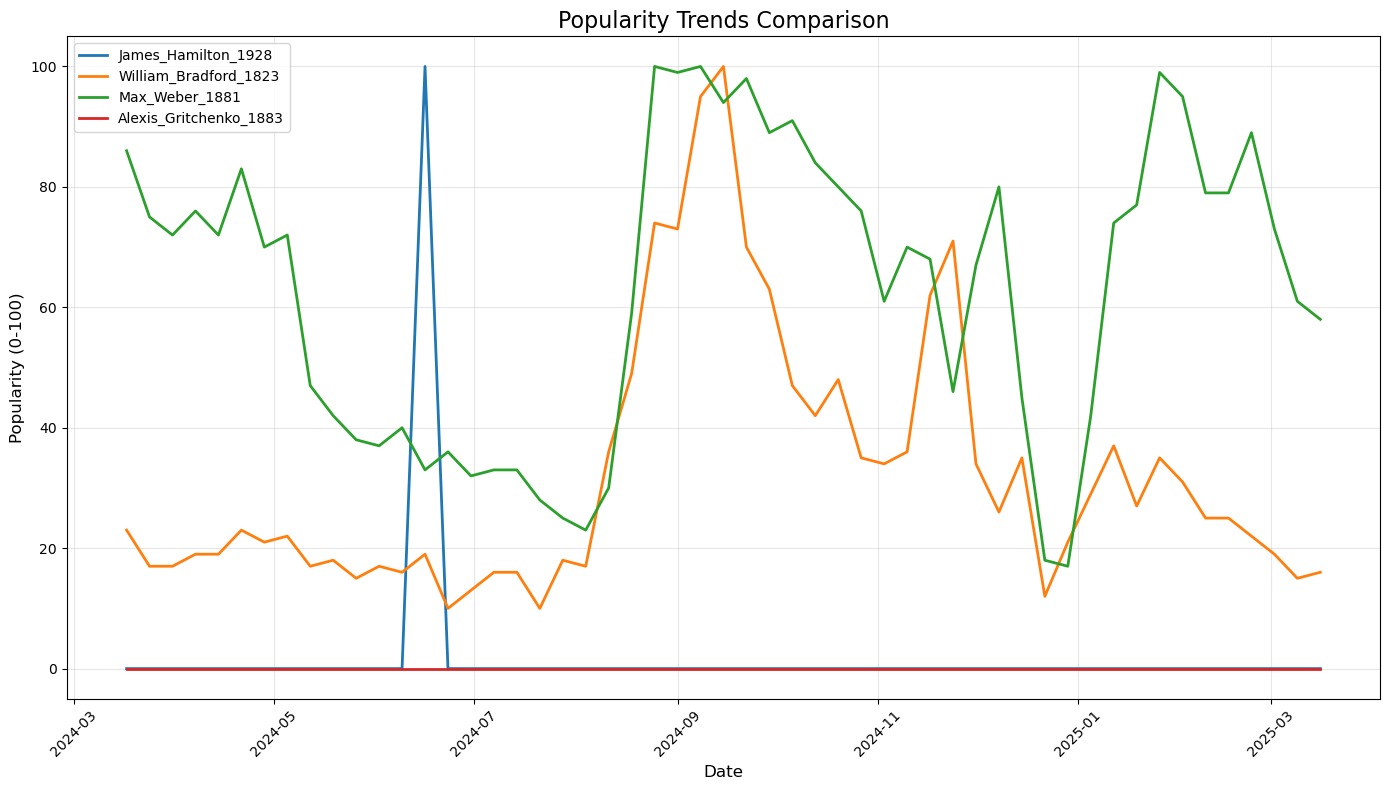

In [33]:
# Compare trends
results = compare_popularity_trends(entity_data)

# Print results
print("Correlation Matrix:")
print(results['correlation_matrix'])
print(f"\nAverage Correlation: {results['average_correlation']:.3f}")
print(f"Interpretation: {results['interpretation']}")

# Show the plot
plt.show()

The romanticists James Hamilton and William Bradford don't seem to share a trend, and the expressionists Max Weber and Alexis Gritchenko don't either. However, William Bradford and Max Weber seem to follow a similar trend.

**We find that the most prolific artists from trends do not trend together.**

### Does an artist passing away influence the popularity of their connections?

Step 1: Query postgres to identify all recently deceased artists

In [ ]:
# Connect to Postgres
conn = psycopg2.connect(
    dbname="dbname",
    user="user",
    password="password",
    host="host",
    port="port"
)
cursor = conn.cursor()

In [ ]:
cursor.execute(
"""
SELECT artist_name, birth_year_key, death_year
FROM artists
WHERE death_year IS NOT NULL
AND death_year >= 2024
AND (artist_name, birth_year_key) IN (
    SELECT artist_name, birth_year_key
    FROM artist_relationships
)
ORDER BY death_year DESC
""", (movement_name,)  # Note the comma to make it a tuple with one element
)

dead_artist = cursor.fetchall()

Step 2: Find those artist's connections (direct or indirect through same school) using Neo4j

In [ ]:
# Connect to your Neo4j database
# Replace with your actual connection details
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

In [ ]:
dead_artists_with_connections = []
# Iterate through the artists list
for artist_name, birth_year, _ in dead_artist:
    # Cypher query to find connections
    find_connections_query = f"""
    // Query to find influential artist connections
    MATCH (source:Artist {{name: '{artist_name}', birth_year: {birth_year}}})

    // Look for direct connections between artists
    // Use regular MATCH instead of OPTIONAL MATCH to ensure we only get non-null results
    MATCH (source)-[r:INFLUENCED_BY|INFLUENCED|IS_PUPIL_OF|TAUGHT|FRIENDS_WITH]-(otherArtist:Artist)

    // Return the connections
    RETURN DISTINCT 
        source.name AS sourceArtistName,
        otherArtist.name AS connectedArtistName,
        otherArtist.birth_year AS connectedArtistBirthYear,
        type(r) AS relationshipType,
        CASE 
            WHEN startNode(r) = source THEN 'outgoing'
            ELSE 'incoming' 
        END AS direction
    ORDER BY connectedArtistName
    """
    
    # Execute query
    try:
        results = graph.run(find_connections_query).to_data_frame()
        
        # Check if artist has connections
        if not results.empty:
            dead_artists_with_connections.append((artist_name, birth_year, results))
            print(f"\nFound {len(results)} connections for {artist_name} (born {birth_year}):")
            print(results)
        else:
            print(f"\nNo connections found for {artist_name} (born {birth_year})")
    except Exception as e:
        print(f"\nError querying for {artist_name}: {str(e)}")


Found Candidate Artist:

Found 16 connections for Frank Stella (born 1936):
   sourceArtistName  connectedArtistName  connectedArtistBirthYear  \
0      Frank Stella         Ad Reinhardt                      1913   
1      Frank Stella         Ad Reinhardt                      1967   
2      Frank Stella         Ad Reinhardt                      1913   
3      Frank Stella          Andy Warhol                      1928   
4      Frank Stella          Andy Warhol                      1928   
5      Frank Stella          Andy Warhol                      1987   
6      Frank Stella        Fernand Leger                      1881   
7      Frank Stella        Fernand Leger                      1955   
8      Frank Stella        Fernand Leger                      1881   
9      Frank Stella  Jessica Stockholder                      1959   
10     Frank Stella  Jessica Stockholder                         0   
11     Frank Stella         Morris Louis                      1912   
12     Frank Stella         Morris Louis                      1962   
13     Frank Stella         Morris Louis                      1912   
14     Frank Stella         Sarah Morris                      1967   
15     Frank Stella         Sarah Morris                         0  

In [87]:
# Close the connection
cursor.close()
conn.close()

**Frank Stella died on May 4, 2024 (age 87 years) in West Village, New York, NY**

Frank Stella's connections that we're going to look at are with Ad Reinhardt, Andy Worhol, Fernand Leger, Jessica Stockholder, Morris Louis, and Sarah Morris

In [6]:
interested_entities = [
    ('artist', 'Ad Reinhardt', 'Ad_Reinhardt_1913'),
    ('artist', 'Andy Warhol', 'Andy_Warhol_1928'),
    ('artist', 'Fernand Leger', 'Fernand_Leger_1881'),
    ('artist', 'Jessica Stockholder', 'Jessica_Stockholder_1959'),
    ('artist', 'Morris Louis', 'Morris_Louis_1912'),
    ('artist', 'Sarah Morris', 'Sarah_Morris_1967'),
]

Step 3: Collect data about connected artists using Google Trends API and store in Redis

In [ ]:
entity_data = {}
for entity in interested_entities:
    # Artist/Artwork/Movement/Place/School/Occupation to search for
    entity_type = entity[0]
    entity_name = entity[1]
    entity_id = entity[2]

    df = trends_to_redis.scrape_entity(entity_name, entity_type, entity_id, DOWNLOADS_FOLDER_FP)
    entity_data[entity_id] = df

In [8]:
# identify artists we couldn't scrape
for curr_entity in interested_entities:
    entity_id = curr_entity[2]
    if entity_id in entity_data.keys():
        continue
    else:
        print(entity_id)

Ad_Reinhardt_1913
Andy_Warhol_1928
Fernand_Leger_1881
Jessica_Stockholder_1959
Morris_Louis_1912
Sarah_Morris_1967


In [ ]:
# for artists that we couldn't scrape, manually download and insert
for curr_entity in interested_entities:
    entity_id = curr_entity[2]
    if (entity_id not in entity_data.keys()) or (entity_data[entity_id] is None):
        df = trends_to_redis.process_scrape(DOWNLOADS_FOLDER_FP, str(entity_id)+".csv", entity_id)
        trends_to_redis.insert_trend_data_from_dataframe(df, "artist", entity_id)
        df = trends_to_redis.retreive_from_redis("artist", entity_id)
        entity_data[entity_id] = df

Correlation Matrix:
                          Ad_Reinhardt_1913  Andy_Warhol_1928  \
Ad_Reinhardt_1913                  1.***REMOVED***00          0.001889   
Andy_Warhol_1928                   0.001889          1.***REMOVED***00   
Fernand_Leger_1881                 0.021431          0.472542   
Jessica_Stockholder_1959           0.108885          0.002173   
Morris_Louis_1912                  0.123601          0.214390   
Sarah_Morris_1967                  0.153109          0.244174   

                          Fernand_Leger_1881  Jessica_Stockholder_1959  \
Ad_Reinhardt_1913                   0.021431                  0.108885   
Andy_Warhol_1928                    0.472542                  0.002173   
Fernand_Leger_1881                  1.***REMOVED***00                  0.158047   
Jessica_Stockholder_1959            0.158047                  1.***REMOVED***00   
Morris_Louis_1912                   0.222615                  0.184983   
Sarah_Morris_1967                  -0.209093

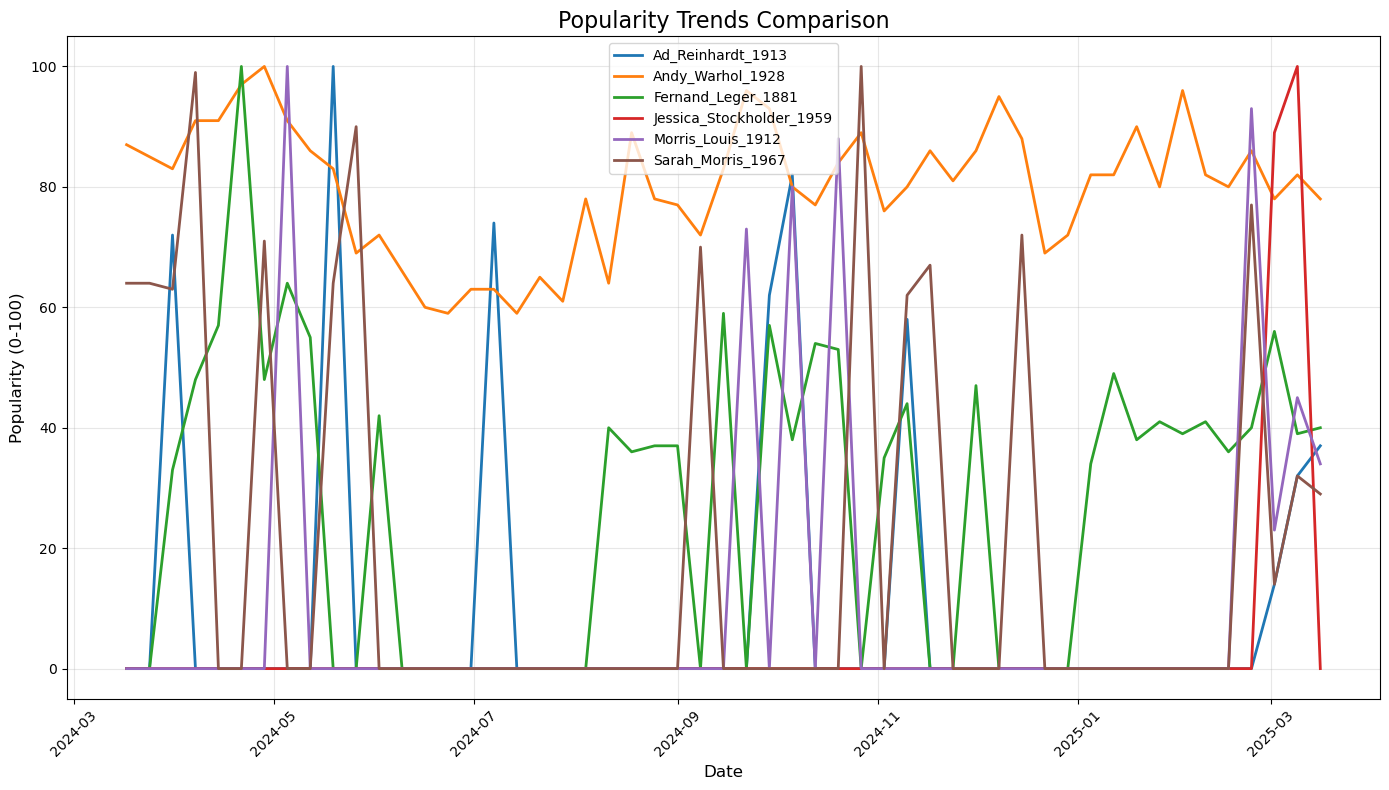

In [17]:
# Compare trends
results = compare_popularity_trends(entity_data)

# Print results
print("Correlation Matrix:")
print(results['correlation_matrix'])
print(f"\nAverage Correlation: {results['average_correlation']:.3f}")
print(f"Interpretation: {results['interpretation']}")

# Show the plot
plt.show()

Initially, we can't see a pattern surrounding other artists' popularity

In [20]:
def compare_popularity_trends_around_may(entity_dataframes):
    """
    Compare popularity trends across multiple entities for April-June 2024,
    highlighting May 4-31.
    
    Parameters:
    -----------
    entity_dataframes : dict
        Dictionary with keys as entity_id and values as dataframes
        Each dataframe has 'Week' (date as string) and 'Popularity' columns
    
    Returns:
    --------
    Dictionary containing correlation matrix and visualization
    """
    
    # Step 1: Convert all dataframes to a common format with datetime index
    processed_dfs = {}
    for entity_id, df in entity_dataframes.items():
        if df is None:
            continue
        # Convert week string to datetime
        temp_df = df.copy()
        
        # Convert the 'Week' column to datetime
        temp_df['date'] = pd.to_datetime(temp_df['Week'])
        
        # Set date as index and sort
        temp_df = temp_df[['Popularity', 'date']]
        temp_df = temp_df.set_index('date').sort_index()
        processed_dfs[entity_id] = temp_df
    
    # Step 2: Create a combined dataframe with all entities
    combined_df = pd.DataFrame()
    for entity_id, df in processed_dfs.items():
        combined_df[f'{entity_id}'] = df['Popularity']  # Using actual entity_id as column name
    
    # Filter to only include April, May, and June 2024
    start_date = pd.Timestamp('2024-04-01')
    end_date = pd.Timestamp('2024-06-30')
    filtered_df = combined_df[(combined_df.index >= start_date) & (combined_df.index <= end_date)]
    
    # Step 3: Calculate correlations between entity popularity trends (using filtered data)
    correlation_matrix = filtered_df.corr()
    
    # Step 4: Visualize trends
    plt.figure(figsize=(14, 8))
    
    # Define the highlight region (May 4 to May 31)
    highlight_start = pd.Timestamp('2024-05-04')
    highlight_end = pd.Timestamp('2024-05-31')
    
    # Add highlight region
    plt.axvspan(highlight_start, highlight_end, color='yellow', alpha=0.3, label='May 4-31 Highlight')
    
    # Plot each entity's popularity
    for entity_id in processed_dfs.keys():
        plt.plot(filtered_df.index, filtered_df[entity_id], 
                 label=entity_id, linewidth=2)
    
    plt.title('Popularity Trends Comparison (April-June 2024)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Popularity (0-100)', fontsize=12)
    
    # Improve date formatting on x-axis
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    #plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))  # Show Mondays
    
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add text annotation for the highlighted period
    plt.annotate('May 4-31 Period', 
                xy=((highlight_start + (highlight_end - highlight_start)/2), filtered_df.min().min()),
                xytext=(0, -30),
                textcoords='offset points',
                ha='center',
                va='top',
                fontsize=12,
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    # Step 5: Calculate overall similarity metric (average correlation)
    # Excluding self-correlations (diagonal)
    mask = ~np.eye(correlation_matrix.shape[0], dtype=bool)
    avg_correlation = correlation_matrix.values[mask].mean()
    
    # Return results
    results = {
        'correlation_matrix': correlation_matrix,
        'average_correlation': avg_correlation,
        'combined_data': filtered_df,
        'interpretation': interpret_similarity(avg_correlation)
    }
    
    return results

Correlation Matrix:
                          Ad_Reinhardt_1913  Andy_Warhol_1928  \
Ad_Reinhardt_1913                  1.***REMOVED***00          0.080127   
Andy_Warhol_1928                   0.080127          1.***REMOVED***00   
Fernand_Leger_1881                -0.284672          0.824981   
Jessica_Stockholder_1959                NaN               NaN   
Morris_Louis_1912                 -0.083333          0.243523   
Sarah_Morris_1967                  0.295358          0.286438   

                          Fernand_Leger_1881  Jessica_Stockholder_1959  \
Ad_Reinhardt_1913                  -0.284672                       NaN   
Andy_Warhol_1928                    0.824981                       NaN   
Fernand_Leger_1881                  1.***REMOVED***00                       NaN   
Jessica_Stockholder_1959                 NaN                       NaN   
Morris_Louis_1912                   0.287423                       NaN   
Sarah_Morris_1967                  -0.134597         

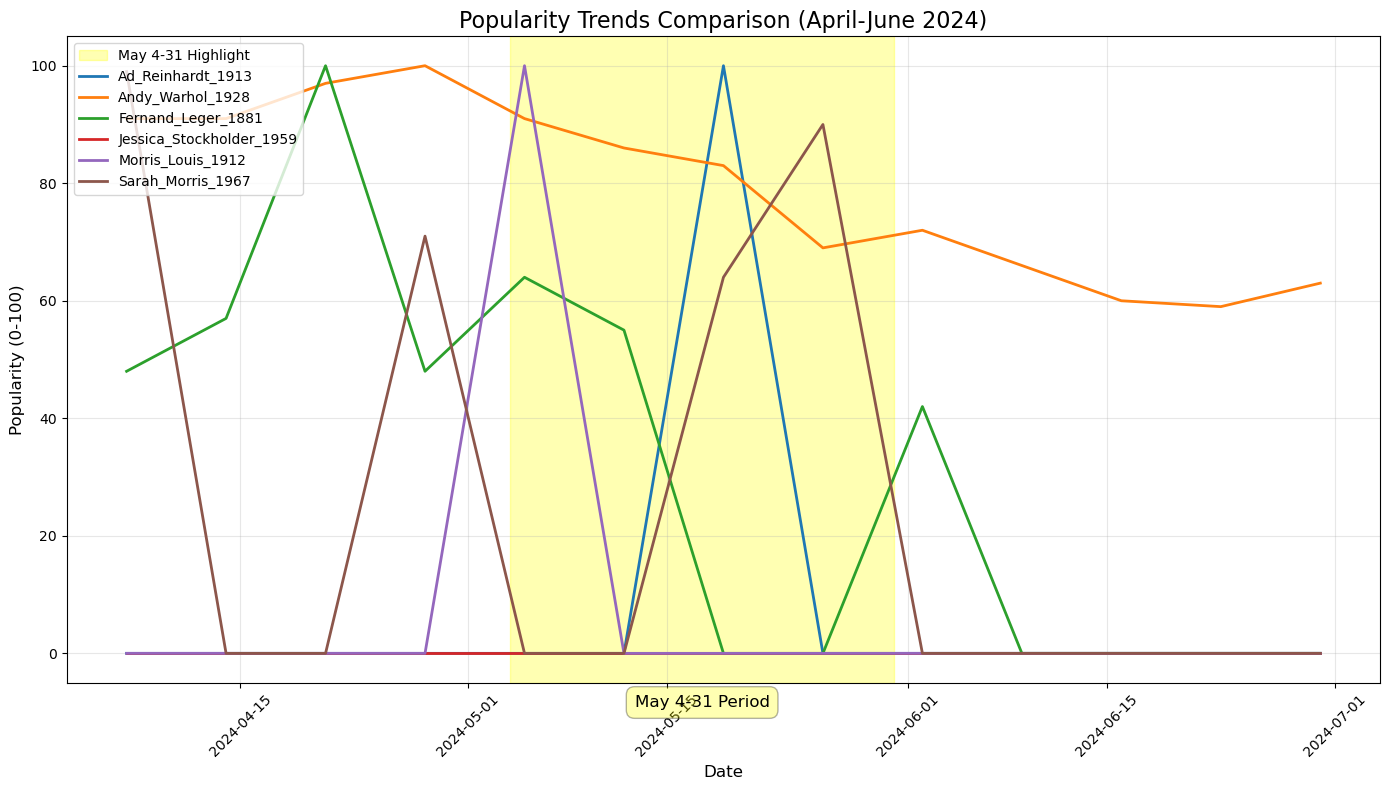

In [21]:
# Compare trends
results = compare_popularity_trends_around_may(entity_data)

# Print results
print("Correlation Matrix:")
print(results['correlation_matrix'])
print(f"\nAverage Correlation: {results['average_correlation']:.3f}")
print(f"Interpretation: {results['interpretation']}")

# Show the plot
plt.show()

When looking deeper into the region surrounding Frank Stella's passing, we find that Morris Louis and Fernand Leger both had spikes in popularity immediately after his passing. Ad Reinhardt and Sarah Morris also had spikes in the month following.

**Thus there is strong evidence that an artist passing away influences the popularity of their connections**